In [1]:
import os
import pandas as pd
from dotenv import load_dotenv
import matplotlib.pyplot as plt


In [2]:
load_dotenv()                                    

FILE_PATH = os.getenv("DATA_DIR")               
SAVE_DIR  = os.getenv("SAVE_DIR")      
WORKBOOK  = "ecosystems_sample_data.xlsx"
out_path  = os.path.join(SAVE_DIR, WORKBOOK)             
os.makedirs(SAVE_DIR, exist_ok=True)             

        
WORKBOOK  = "ecosystems_sample_data.xlsx"
out_path  = os.path.join(SAVE_DIR, WORKBOOK)                     


In [ ]:

cb_df = pd.read_excel(
    FILE_PATH,          
    sheet_name=1,       
    engine="openpyxl",  
    header=0,           
    dtype=str        
)

print(f"Loaded {cb_df.shape[0]:,} rows × {cb_df.shape[1]} columns.")
print(cb_df.columns.tolist())        

Loaded 91,433 rows × 36 columns.
['uuid', 'Ecosystem', 'name', 'type', 'permalink', 'created_at', 'updated_at', 'domain', 'homepage_url', 'country_code', 'state_code', 'region', 'city', 'address', 'postal_code', 'status', 'short_description', 'category_list', 'category_groups_list', 'num_funding_rounds', 'total_funding_usd', 'total_funding', 'total_funding_currency_code', 'founded_on', 'closed_on', 'employee_count', 'email', 'phone', 'description', 'founded_year', 'source', 'Is_True', 'Digital Transition Keywords', 'Green Transition Keywords', 'Digital transition', 'Green transition']


In [4]:


# %% ---------- GENERATE SAMPLES FROM DATASET ----------



def generate_samplesets(
    df: pd.DataFrame,
    ecosystems,                       # str | list-like of str
    n: int = 150,
    tgt = None,                       # None=SRS · "auto"=proportional · 0–1=float
    label_col: str = "Is_True",
    eco_col: str = "Ecosystem",
    seed: int | None = 42
) -> dict[str, pd.DataFrame]:
    """
    Sample `n` rows for one or more ecosystems.

    Returns
    -------
    dict : {ecosystem_name -> sampled DataFrame}
    """
    # normalise ecosystems → list
    if isinstance(ecosystems, (str, bytes)):
        ecosystems = [ecosystems]
    ecosystems = list(ecosystems)               # make indexable

    samples = {}
    for eco in ecosystems:
        d = df[df[eco_col] == eco]
        if len(d) < n:
            raise ValueError(f"{eco}: only {len(d)} rows; need {n}.")

        # --- design
        if tgt is None:                         # Simple Random Sample
            sample = d.sample(n, random_state=seed)
        else:                                   # Stratified
            tgt_pct = (d[label_col].eq("Yes").mean()
                       if tgt == "auto" else float(tgt))
            y_n = int(round(n * tgt_pct)); n_n = n - y_n
            y  = d[d[label_col] == "Yes"].sample(y_n, random_state=seed)
            n_ = d[d[label_col] == "No" ].sample(n_n, random_state=seed)
            sample = pd.concat([y, n_]).sample(frac=1, random_state=seed)

        samples[eco] = sample.copy()
    
    # return dict normally; but if only one ecosystem was asked for, return the DF directly
    if len(ecosystems) == 1:
        return samples[ecosystems[0]]
    return samples

 
# -------------------------------------------------------------------



# %% ---------- count  label distribution within the sample data across ecosystems ----------

def count_label_distribution(
    eco_samples, 
    label_col="Is_True", 
    labels=("Yes", "No")
):
    """
    Counts the number of 'Yes' and 'No' (case-insensitive) in label_col for each ecosystem sample.

    Returns a DataFrame:
    | Ecosystem | Yes | No |
    """
    # Normalize labels to lowercase for matching
    labels_lower = [l.lower() for l in labels]
    rows = []
    for eco, df in eco_samples.items():
        # Convert column values to lowercase, strip whitespace
        values = df[label_col].str.lower().str.strip()
        counts = values.value_counts().reindex(labels_lower).fillna(0).astype(int)
        # Map back to original label order for DataFrame
        rows.append({
            "Ecosystem": eco,
            labels[0]: counts.get(labels_lower[0], 0),
            labels[1]: counts.get(labels_lower[1], 0)
        })
    return pd.DataFrame(rows).set_index("Ecosystem")

In [13]:
ecosystems = cb_df["Ecosystem"].dropna().unique()
eco_samples = generate_samplesets(cb_df, ecosystems, n=150, tgt="auto", seed=42)
sampling_dist = count_label_distribution(eco_samples)
print(sampling_dist)




              Yes   No
Ecosystem             
Electronics    53   97
Retail         61   89
CCI            88   62
Health          0  150
Tourism        91   59
Mobility      148    2
Chemical      113   37
Textiles      121   29
Agrifood      144    6
Construction   93   57


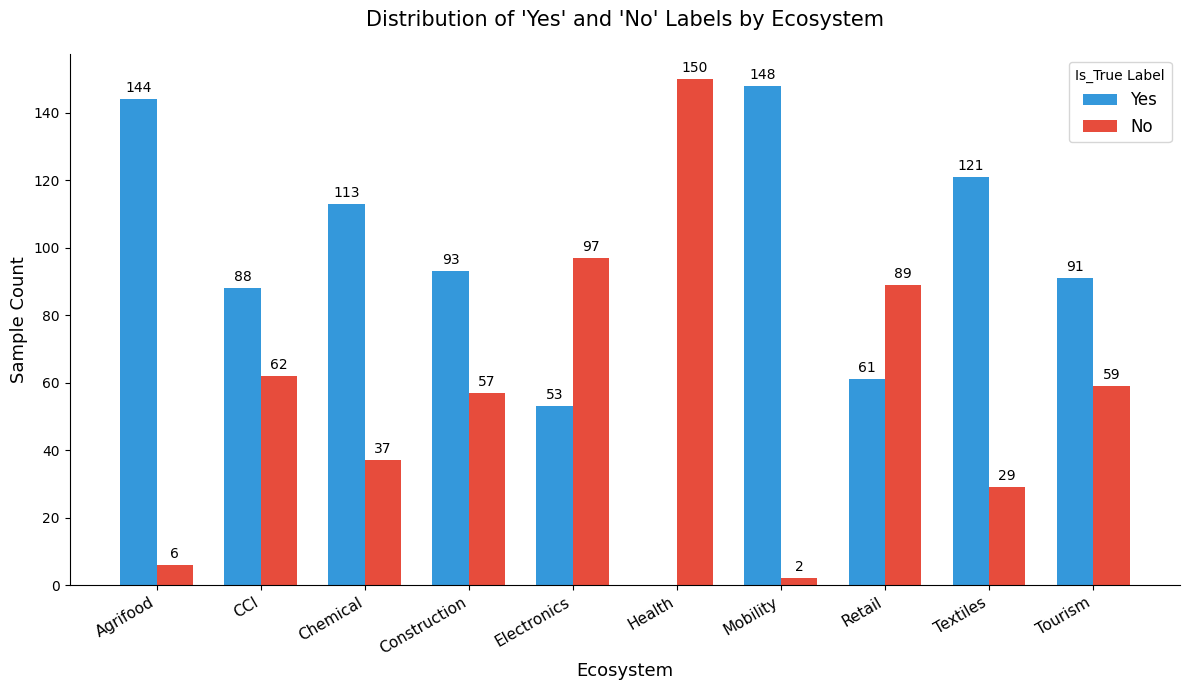

In [14]:
# Ensure consistent order (alphabetical by ecosystem)
sampling_dist = sampling_dist.sort_index()

fig, ax = plt.subplots(figsize=(12, 7))

# Bar width
bar_width = 0.35
x = range(len(sampling_dist.index))

# Bar positions
bar1 = [val for val in sampling_dist["Yes"]]
bar2 = [val for val in sampling_dist["No"]]

# Plot bars
rects1 = ax.bar([i - bar_width/2 for i in x], bar1, bar_width, label="Yes", color="#3498db")
rects2 = ax.bar([i + bar_width/2 for i in x], bar2, bar_width, label="No",  color="#e74c3c")

# Customization
ax.set_xticks(list(x))
ax.set_xticklabels(sampling_dist.index, rotation=30, ha='right', fontsize=11)
ax.set_ylabel("Sample Count", fontsize=13)
ax.set_xlabel("Ecosystem", fontsize=13)
ax.set_title("Distribution of 'Yes' and 'No' Labels by Ecosystem", fontsize=15, pad=20)
ax.legend(title="Is_True Label", fontsize=12)

# Annotate bars
for rect in rects1 + rects2:
    height = rect.get_height()
    if height > 0:
        ax.annotate(f"{height}",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, color='black')

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()


In [ ]:
textile_sample = generate_samplesets(cb_df, "Textiles", n=150, tgt=None)
textile_sample_auto = generate_samplesets(cb_df, "Textiles", n=150, tgt="auto")

# prep counts
cnt_textile = textile_sample["Is_True"].value_counts().reindex(labels).fillna(0)
cnt_textile_auto = textile_sample_auto["Is_True"].value_counts().reindex(labels).fillna(0)
# plot side-by-side
x     = np.arange(len(labels))          
width = 0.35
fig, ax = plt.subplots()
ax.bar(x - width/2, cnt_textile, width, label="Random")
ax.bar(x + width/2, cnt_textile_auto, width, label="Proportional")
ax.set_title("Textiles – Is_True distribution (150-row samples)")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Count")
ax.legend()
plt.show()


In [ ]:
# Define function parameters
N           = 150          # rows per ecosystem
YES_POLICY  = None         # None=SRS · "auto"=proportional · 0–1=float
SEED        = 42
WORKBOOK    = "ecosystems_sample_data.xlsx"   # output file name



# %% ── 1. list ecosystems ───────────────────────────────────────────────
ecosystems = cb_df["Ecosystem"].dropna().unique()

# Run function to extract sample data N = 150 rows per ecosystem
# and save to dictionary
# (ecosystem name as key, DataFrame as value)
eco_samples = generate_samplesets(
    cb_df,
    ecosystems,
    n   = N,
    tgt = YES_POLICY,
    seed= SEED
)

# %% ── 3. add annotation columns ────────────────────────────────────────
for df in eco_samples.values():
    df["Human_Label"] = ""
   

# %% ── 4. merge for programmatic work ───────────────────────────────────
merged_sample_data = (
    pd.concat(eco_samples.values(), ignore_index=True)
      .reset_index(drop=True)
)
print(f"merged_sample_data shape: {merged_sample_data.shape}")

#  ── 5. export workbook with trimmed columns ──────────────────────────
keep_cols = [
    "name", "domain", "permalink", "short_description",
     "description", "Human_Label"
]

# Write sample data to an excel workbook
# with one sheet per ecosystem
with pd.ExcelWriter(out_path, engine="xlsxwriter") as writer:
    for eco, df in eco_samples.items():
        df_reduced = df.reindex(columns=keep_cols)
        df_reduced.to_excel(writer,
                            sheet_name=eco[:31] or "Sheet",
                            index=False)

        # ── format after the sheet is created 
        ws = writer.sheets[eco[:31] or "Sheet"]
        wb = writer.book
        wrap = wb.add_format({"text_wrap": True, "valign": "top"})

        # A:F → the six columns we kept; set width = 45 chars & wrap
        ws.set_column("A:F", 45, wrap)

In [ ]:


data_dir  = os.path.dirname(FILE_PATH)
AERO_FILE = os.path.join(data_dir, "Aerospace_merged.xlsx")

aero_df = pd.read_excel(AERO_FILE, sheet_name=0, dtype=str, engine="openpyxl")
aero_df["Ecosystem"] = "Aerospace"


In [ ]:
# SAMPLE: no ["Aerospace"] this time
aero_sample = generate_samplesets(
    aero_df,
    "Aerospace",   # single ecosystem → function returns a DataFrame
    n   = N,
    tgt = YES_POLICY,
    seed= SEED
)

In [ ]:
# now aero_sample is already the DataFrame you want
aero_sample["Human_Label"]   = ""
eco_samples["Aerospace"]     = aero_sample

# re-export (same as before)
keep_cols = ["name","domain","permalink","short_description","description","Human_Label"]
with pd.ExcelWriter(out_path, engine="xlsxwriter") as writer:
    for eco, df in eco_samples.items():
        df_reduced = df.reindex(columns=keep_cols)
        sheet = eco[:31] or "Sheet"
        df_reduced.to_excel(writer, sheet_name=sheet, index=False)
        ws   = writer.sheets[sheet]
        wb   = writer.book
        wrap = wb.add_format({"text_wrap": True, "valign": "top"})
        ws.set_column("A:F", 45, wrap)

print("✔️ Updated workbook saved to:", out_path)